In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from scipy.special import digamma
%matplotlib inline
from ct_charachterization.utility.utils import central_gamma_pdf
from glob import glob
import pydicom as dicom
import dicom_numpy
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt
from scipy.stats import mode

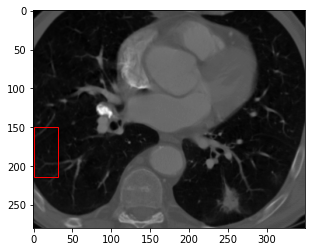

In [2]:
import matplotlib.patches as patches
img = np.load(f'''../resources/luna_cropped.npy''')
fig1, ax1 = plt.subplots(1)
ax1.imshow(img, cmap='gray')
rect = patches.Rectangle((0, 150),32,64,linewidth=1,edgecolor='r',facecolor='none')
ax1.add_patch(rect)
plt.show()

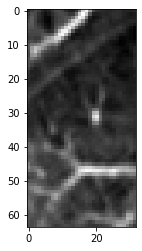

(64, 32)
-963 -836.33837890625 -459


In [3]:
from copy import deepcopy

neighborhood = deepcopy(img[150:214, :32])
plt.imshow(neighborhood, cmap='gray')
plt.show()
print(neighborhood.shape)
print(np.min(neighborhood), np.mean(neighborhood), np.max(neighborhood))

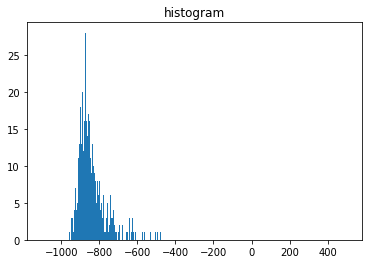

In [4]:
flat = neighborhood.flatten()
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
plt.title("histogram")
plt.show()

In [5]:
from scipy.stats import mode
mode(flat)

ModeResult(mode=array([-873], dtype=int16), count=array([28]))

In [6]:
delta = - 1030
mu = np.array([-987, -870, -540, -370, -160, 0, 100, 240, 340]) - delta
J = len(mu)

In [7]:
# initializing values

global_alpha = np.ones((J)) * 2
global_beta = np.array([mu[j]/global_alpha[j] for j in range(J)])
global_pi = np.ones((J)) / J

In [8]:
y = np.expand_dims(neighborhood, axis=-1) - delta
alpha = np.expand_dims(np.expand_dims(global_alpha, axis=0), axis=0)
beta = np.expand_dims(np.expand_dims(global_beta, axis=0), axis=0)
pi = np.expand_dims(np.expand_dims(global_pi, axis=0), axis=0)
gamma = pi * central_gamma_pdf(y, alpha=alpha, beta=beta)

In [9]:
def _get_alphas_solution(right_hand_side, previous_alpha):
    alpha_optimizer = lambda alpha_var: right_hand_side - (np.log(alpha_var) - digamma(alpha_var))
    alpha_solution = fsolve(alpha_optimizer, previous_alpha)
    return alpha_solution

vectorized_get_alphas_solution = np.vectorize(_get_alphas_solution)

In [10]:
def do_iterations(y, mu, alpha, beta, pi, gamma):
    expanded_mu = np.expand_dims(np.expand_dims(mu, axis=0), axis=0)
    err = np.Infinity
    tol = 0.000001
    n = 0
    max_iter = 10
    while err > tol and n < max_iter:
        n += 1
        right_hand_side = ((np.sum(gamma*y/expanded_mu, axis=(0,1)) - np.sum(gamma*np.log(y/expanded_mu), axis=(0,1))) / (np.sum(gamma, axis=(0,1)))) - 1
        right_hand_side = np.expand_dims(np.expand_dims(right_hand_side, axis=0), axis=0)
        new_alpha = vectorized_get_alphas_solution(right_hand_side, alpha)
        new_beta = expanded_mu / new_alpha
        new_pi = (np.sum(gamma, axis=(0,1))) / y.size
        err = np.linalg.norm(np.array([new_alpha.ravel(), new_beta.ravel(), new_pi.ravel()]) - np.array([alpha.ravel(), beta.ravel(), pi.ravel()])) / np.linalg.norm(np.array([alpha.ravel(), beta.ravel(), pi.ravel()]))
        gamma = pi * central_gamma_pdf(y, alpha=alpha, beta=beta)
        alpha = new_alpha
        beta = new_beta
        pi = new_pi
        print(n, err)
    return alpha, beta, pi, gamma

In [11]:
alpha, beta, pi, gamma = do_iterations(y, mu, alpha, beta, pi, gamma)

1 0.24582302053711816
2 1.0222644247962984e-14


<ipython-input-9-b76b0093ae12>:2: RuntimeWarning: invalid value encountered in log
  alpha_optimizer = lambda alpha_var: right_hand_side - (np.log(alpha_var) - digamma(alpha_var))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [12]:
print(np.isnan(np.sum(alpha)), np.isnan(np.sum(beta)),np.isnan(np.sum(pi)), np.isnan(np.sum(gamma)))

False False False False


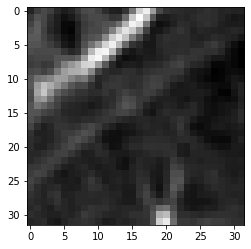

(32, 32, 1)


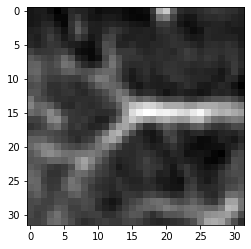

(32, 32, 1)


In [13]:
y_1 = y[0:32, :, :]
y_2 = y[32:64, :, :]

plt.imshow(y_1[:,:,0], cmap='gray')
plt.show()
print(y_1.shape)
plt.imshow(y_2[:,:,0], cmap='gray')
plt.show()
print(y_2.shape)

In [14]:
from copy import deepcopy

alpha_1 = deepcopy(alpha)
beta_1 = deepcopy(beta)
pi_1 = deepcopy(pi)
gamma_1 = pi_1 * central_gamma_pdf(y_1, alpha=alpha_1, beta=beta_1)

alpha_1, beta_1, pi_1, gamma_1 = do_iterations(y_1, mu, alpha_1, beta_1, pi_1, gamma_1)




alpha_2 = deepcopy(alpha)
beta_2 = deepcopy(beta)
pi_2 = deepcopy(pi)
gamma_2 = pi_2 * central_gamma_pdf(y_2, alpha=alpha_2, beta=beta_2)

alpha_2, beta_2, pi_2, gamma_2 = do_iterations(y_2, mu, alpha_2, beta_2, pi_2, gamma_2)



1 0.12086795936556499
2 0.0
1 0.05509226823521722
2 1.9055571578172987e-14


<ipython-input-9-b76b0093ae12>:2: RuntimeWarning: invalid value encountered in log
  alpha_optimizer = lambda alpha_var: right_hand_side - (np.log(alpha_var) - digamma(alpha_var))


In [15]:
print(np.isnan(np.sum(alpha_1)), np.isnan(np.sum(beta_1)),np.isnan(np.sum(pi_1)), np.isnan(np.sum(gamma_1)))
print(np.isnan(np.sum(alpha_2)), np.isnan(np.sum(beta_2)),np.isnan(np.sum(pi_2)), np.isnan(np.sum(gamma_2)))

False False False False
False False False False


-1008 -987


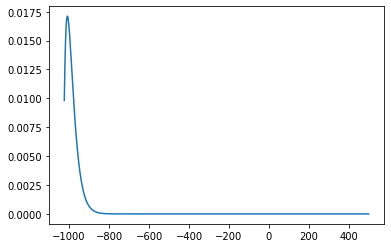

-882 -870


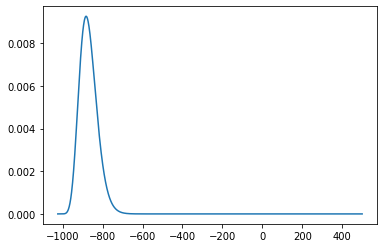

-877 -540


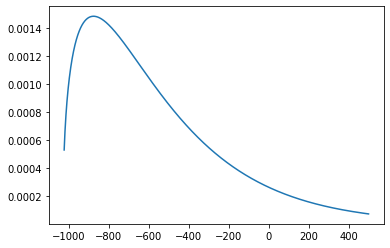

-1011 -370


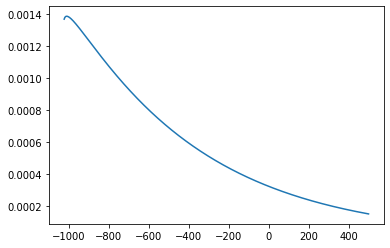

-595 -160


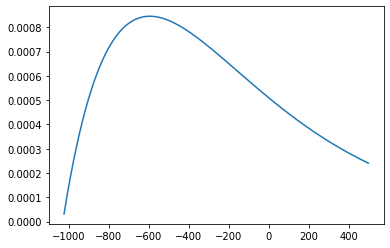

-515 0


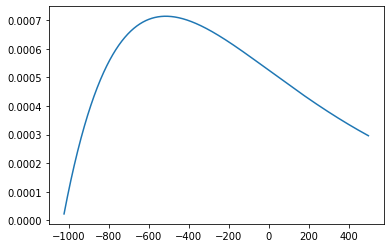

-465 100


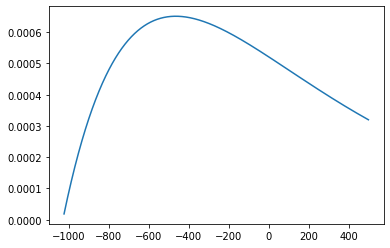

-395 240


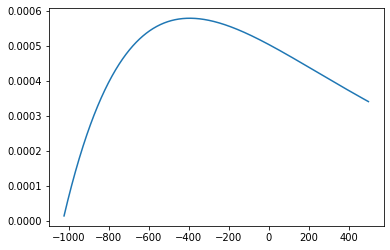

-345 340


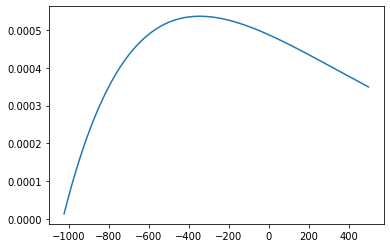

In [16]:
for j in range(J):
    wanted_alpha = alpha[0, 0, j]
    wanted_beta = beta[0, 0, j]
    xs = np.arange(-1024, 500, 1) + 1030
    ys = central_gamma_pdf(xs, wanted_alpha, wanted_beta).ravel()
    plt.plot(xs - 1030, ys, '-')
    print(xs[np.argmax(ys)] -1030, mu[j] - 1030)
    plt.show()

In [17]:
constant_c = 10
first_local_moment_numerator_1 = np.sum(np.sqrt(y_1)*gamma_1, axis=(0,1))
first_local_moment_numerator_2 = np.sum(np.sqrt(y_2)*gamma_2, axis=(0,1))
second_local_moment_numerator_1 = np.sum(y_1*gamma_1, axis=(0,1))
second_local_moment_numerator_2 = np.sum(y_2*gamma_2, axis=(0,1))
denumerator_1 = np.sum(gamma_1, axis=(0,1))
denumerator_2 = np.sum(gamma_2, axis=(0,1))
first_local_moment_1 = first_local_moment_numerator_1 / denumerator_1
first_local_moment_2 = first_local_moment_numerator_2 / denumerator_2
second_local_moment_1 = second_local_moment_numerator_1 / denumerator_1
second_local_moment_2 = second_local_moment_numerator_2 / denumerator_2
var_1 = second_local_moment_1 - np.power(first_local_moment_1, 2)
var_2 = second_local_moment_2 - np.power(first_local_moment_2, 2)
y_stab_1 = (constant_c * (np.expand_dims(np.sqrt(y_1), axis=-1) - first_local_moment_1) / np.sqrt(var_1)) + second_local_moment_1
y_stab_2 = (constant_c * (np.expand_dims(np.sqrt(y_2), axis=-1) - first_local_moment_2) / np.sqrt(var_2)) + second_local_moment_2

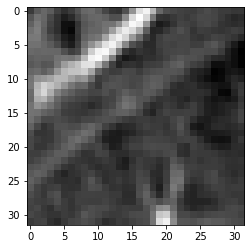

-926.2375034410766 -874.0505495736865 -746.0301091838335


In [18]:
to_show = y_stab_1[..., 1]
plt.imshow(to_show, cmap='gray')
plt.show()
print(np.min(to_show) - 1030, np.mean(to_show) - 1030, np.max(to_show) - 1030)

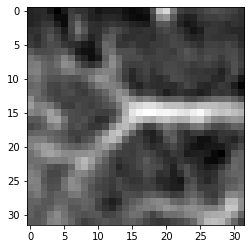

-894.4616575070587 -842.2347650941182 -739.6210848616126


In [19]:
to_show = y_stab_2[..., 1]
plt.imshow(to_show, cmap='gray')
plt.show()
print(np.min(to_show) - 1030, np.mean(to_show) - 1030, np.max(to_show) - 1030)

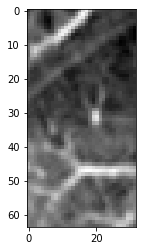

-926.2375034410766 -858.1426573339023 -739.6210848616126


In [20]:
y_stab = np.empty(tuple(list(y.shape) + [J]))
y_stab[0:32, ...] = y_stab_1
y_stab[32:64, ...] = y_stab_2

plt.imshow(y_stab[..., 1], cmap='gray')
plt.show()
print(np.min(y_stab[..., 1]) - 1030, np.mean(y_stab[..., 1]) - 1030, np.max(y_stab[..., 1]) - 1030)

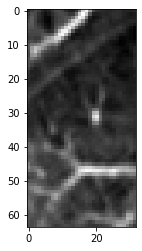

(64, 32)
-963 -836.33837890625 -459


In [21]:
plt.imshow(neighborhood, cmap='gray')
plt.show()
print(neighborhood.shape)
print(np.min(neighborhood), np.mean(neighborhood), np.max(neighborhood))


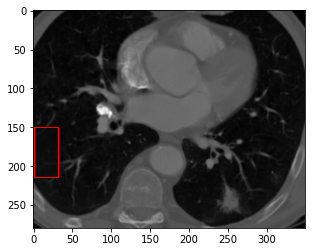

In [22]:
img[150:214, :32] = (y_stab[..., 1].squeeze() - 1030)
fig1, ax1 = plt.subplots(1)
ax1.imshow(img, cmap='gray')
rect = patches.Rectangle((0, 150),32,64,linewidth=1,edgecolor='r',facecolor='none')
ax1.add_patch(rect)
plt.show()